In [226]:
%matplotlib notebook
import os
import pandas as pd
import re
import numpy as np
import collections
import biosppy.signals
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn import svm
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from keras.wrappers.scikit_learn import KerasRegressor

In [2]:
DATA_TRAIN_PATH = 'blood-pressure-estimation-data/data_train'
DATA_TEST1_PATH = 'blood-pressure-estimation-data/data_test1_blank'
DATA_TEST2_PATH = 'blood-pressure-estimation-data/data_test2_blank'

In [597]:
class TRecord:
    def __init__(self, sample_id, sbp, dbp, ppg, ecg, uid):
        self.sample_id = sample_id
        self.sbp = sbp
        self.dbp = dbp
        self.uid = uid
        
        out_ecg = biosppy.signals.ecg.ecg(signal=np.array(ecg, dtype=float), sampling_rate=500., show=False)
        self.ecg = out_ecg['filtered']
        self.ppg = biosppy.signals.tools.filter_signal(signal=ppg,
                                      ftype='bessel',
                                      band='bandpass',
                                      order=3,
                                      frequency=[1, 4],
                                      sampling_rate=500.)[0]
        
        # find onsets
        self.ppg_peaks, = biosppy.signals.bvp.find_onsets(signal=self.ppg, sampling_rate=500., wrange=0.1)
        if (len(self.ppg_peaks) == 0):
            print('bad')
            ax = plt.figure().gca()
            ax.plot(self.ppg)
            pass
        
        self.ppg_extrema = biosppy.signals.tools.find_extrema(self.ppg)[0]
            
        n = len(ecg)
        Fs = 500.
        k = np.arange(n)
        T = n / Fs
        frq = k / T # two sides frequency range
        #frq = frq[range(n//2)] # one side frequency range
        self.ecg_fft = abs(np.fft.fft(out_ecg['filtered']))
        self.ecg_fft = np.log(self.ecg_fft[range(int(T), 250 * int(T), int(T))])
        
        self.hr = out_ecg['heart_rate']
        self.ecg_peaks = out_ecg['rpeaks']
        
        self.foot_points = []
        self.notch = []
        self.diastolic_peak = []
        # ppg_peaks
        ppg_max = []
        for j in range(len(self.ppg_peaks)):
            pos = self.ppg_extrema.searchsorted(self.ppg_peaks[j])
            if pos + 2 < len(self.ppg_extrema):
                self.diastolic_peak.append(self.ppg_extrema[pos + 2])
            if pos + 1 < len(self.ppg_extrema):
                self.notch.append(self.ppg_extrema[pos + 1])
            if pos < len(self.ppg_extrema):
                ppg_max.append(self.ppg_extrema[pos])
            if pos - 1 >= 0:
                self.foot_points.append(self.ppg_extrema[pos - 1])
        self.ppg_peaks_old = self.ppg_peaks.copy()
        self.ppg_peaks = np.array(ppg_max.copy())
        
        
        self.foot_points = np.array(self.foot_points)
        self.notch = np.array(self.notch)
        self.diastolic_peak = np.array(self.diastolic_peak)
       
    def __str__(self):
        return '\n{sample_id: %s \n sbp, dbp: %d, %d\n ppg: %s\n ecg: %s\n ppg_peaks: %s\n}' % (self.sample_id, self.sbp, self.dbp, str(self.ppg[:8]), str(self.ecg[:8]), "")
    
    def __repr__(self):
        return str(self)
        
def parse_name(name):
    r = re.search("subj(\\d+)log(\\d+)\\.csv", name)
    return (r.group(1), r.group(2))

def load_data(path, skip = 3000, is_train = False):
    filenames = os.listdir(path)
    data = {}
    filenames.sort()
    for idx, file in enumerate(filenames):
#         if idx > 10:
#             break
        uid, saimpe_id = parse_name(file)
        ppg = []
        ecg = []
        with open(path + '/' + file, 'r') as f:
            for id, line in enumerate(f):
                vals = line[:-1].split(',')
                if id == 0:
                    sbp, dbp = float(vals[0]), float(vals[1])
                    continue
                ppg.append(float(vals[0]))
                ecg.append(float(vals[1]))
        
        try:
            if uid not in data:
                data[uid] = collections.defaultdict(list)
            rec = TRecord(saimpe_id, sbp, dbp, ppg[skip:], ecg[skip:], uid)
            data[uid]['bp' if sbp != 0 else 'nbp'].append(rec)
        except Exception as e:
            if is_train:
                print(e)
                pass
            else:
                raise
    return data
        
data_test = load_data(DATA_TEST1_PATH)
data_test2 = load_data(DATA_TEST2_PATH)
data_train = load_data(DATA_TRAIN_PATH, is_train=True)

Not enough beats to compute heart rate.
Not enough beats to compute heart rate.
Not enough beats to compute heart rate.


<IPython.core.display.Javascript object>


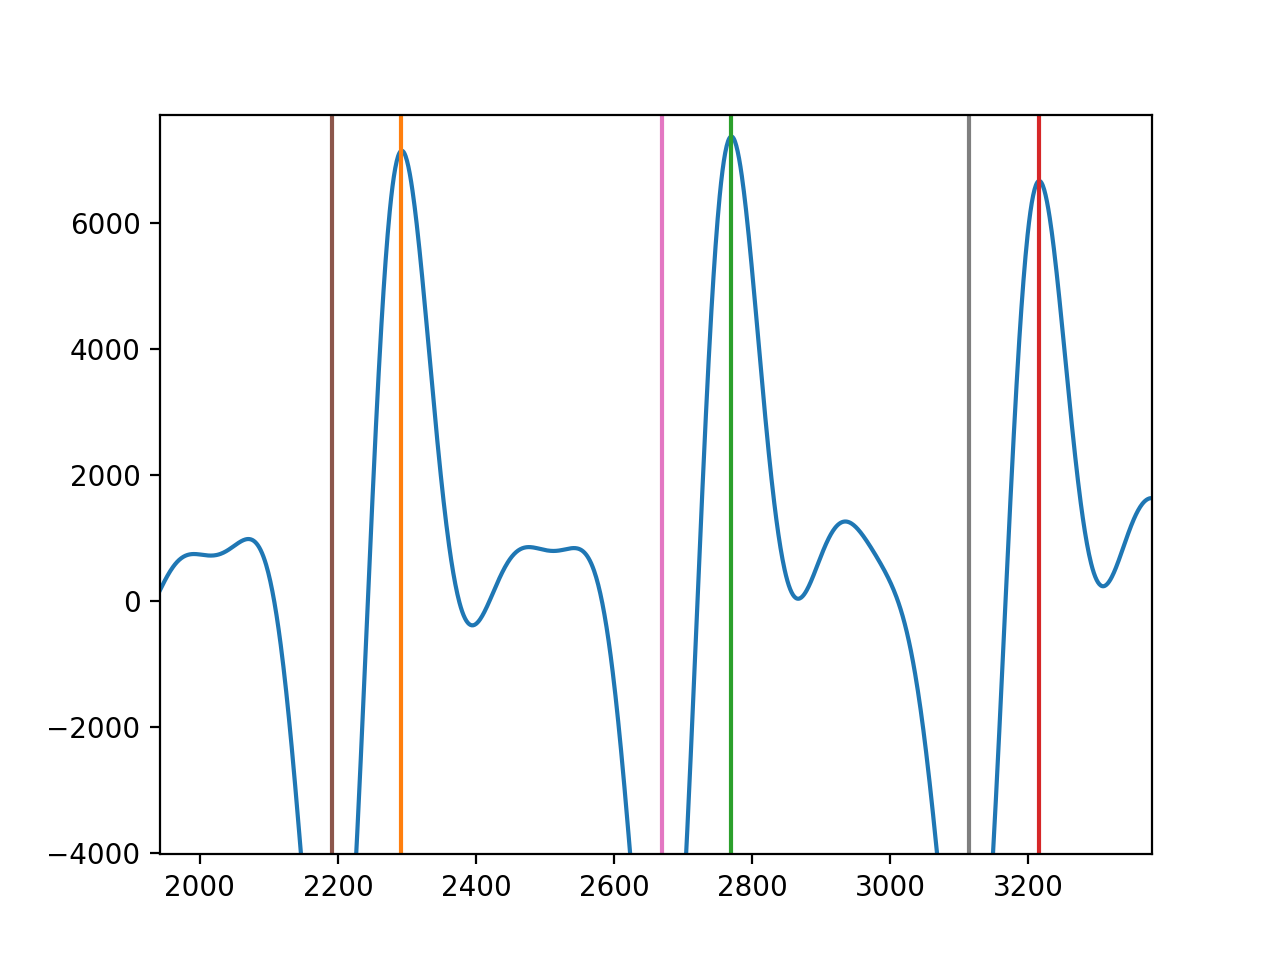

<IPython.core.display.Javascript object>


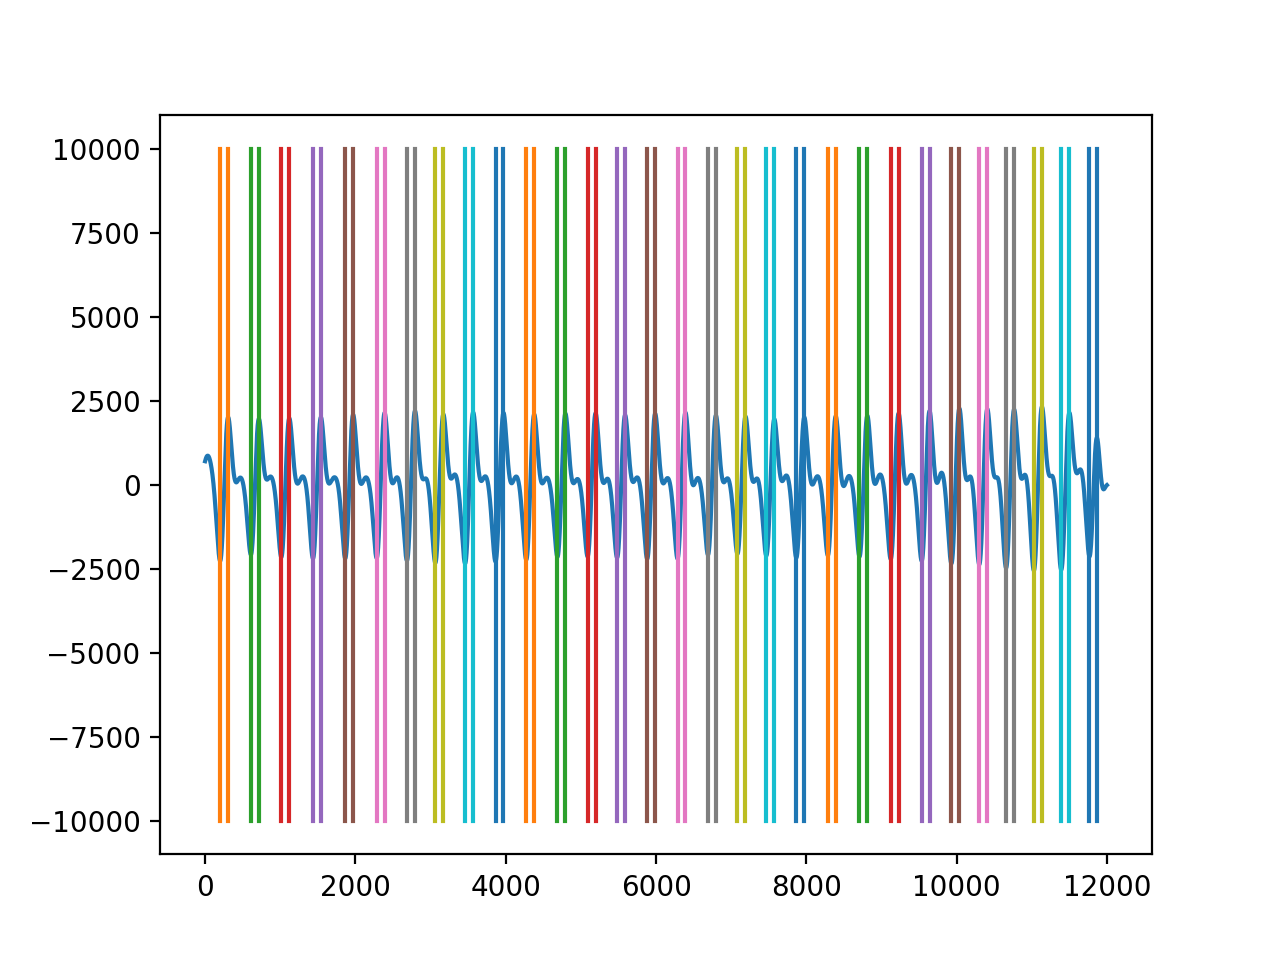

<IPython.core.display.Javascript object>


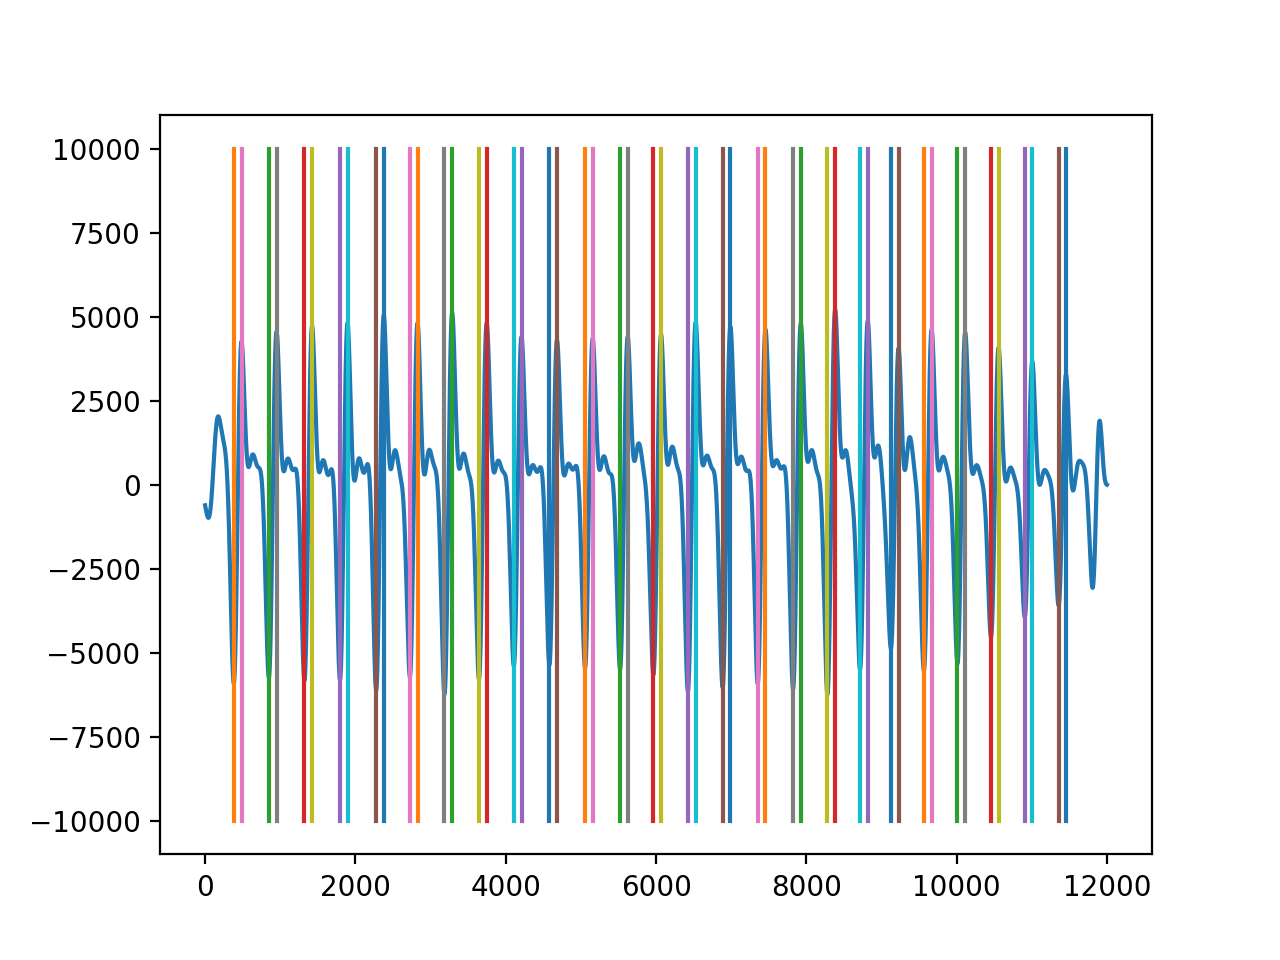

<IPython.core.display.Javascript object>


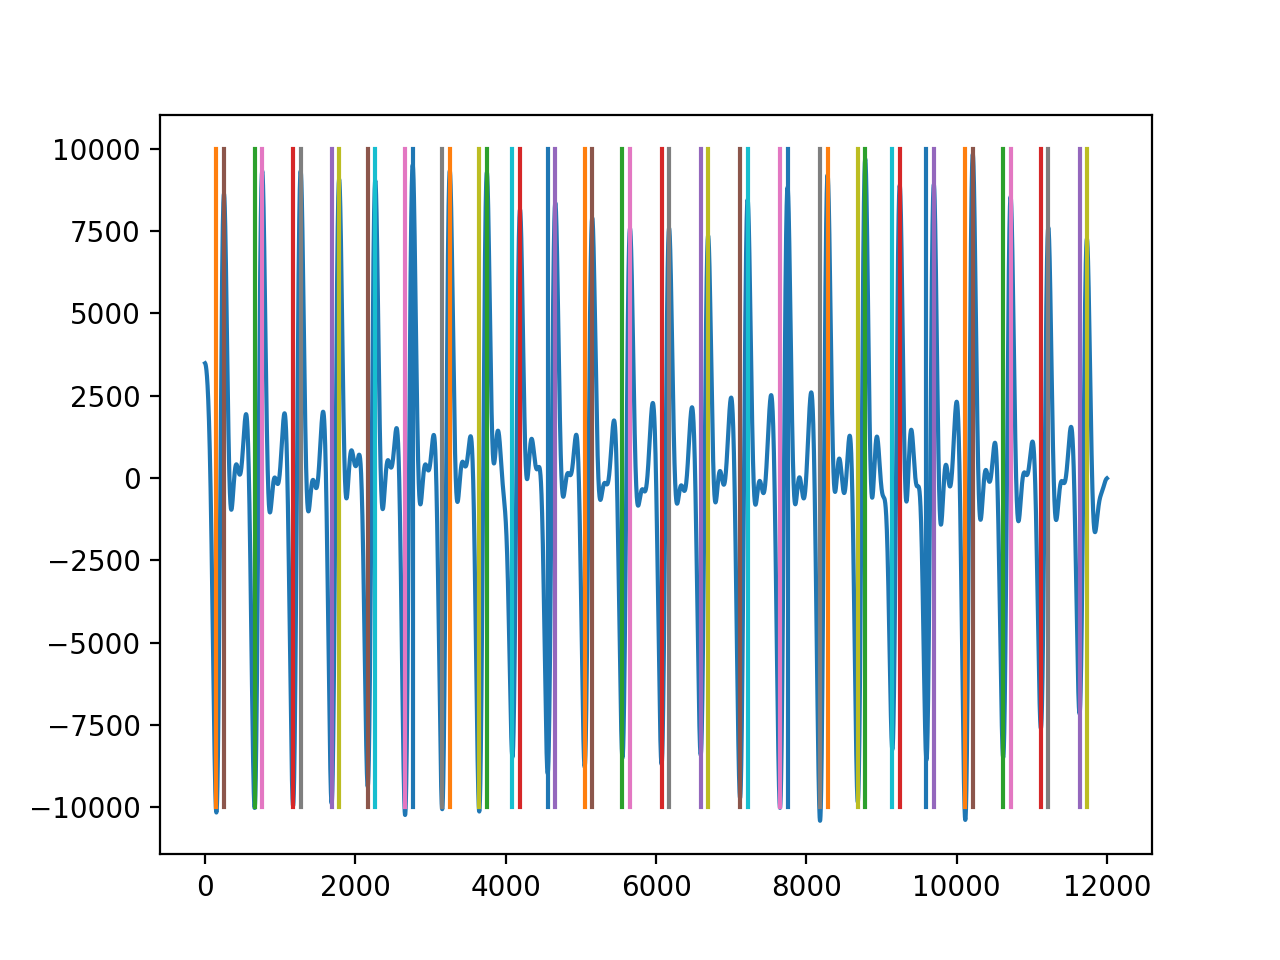

In [596]:
#ax = plt.figure().gca()
for id, uid in enumerate(data_train):
    mn = 1
    for idx, rec in enumerate(data_train[uid]['bp']):
        if (idx > 3):
            break
#         PTT = []
#         PTTb = []
#         for j in range(len(rec.ecg_peaks)):
#             ecg_p = rec.ecg_peaks[j]
#             pos = rec.ppg_peaks.searchsorted(ecg_p)
#             if pos < len(rec.ppg_peaks):
#                 ptt_val = rec.ppg_peaks[pos] - ecg_p
#                 if ptt_val > 70 and ptt_val < 200:
#                     PTT.append(rec.ppg_peaks[pos] - ecg_p)
                    
#             pos = rec.foot_points.searchsorted(ecg_p)
#             if pos < len(rec.foot_points):
#                 pttb_val = rec.foot_points[pos] - ecg_p
#                 if pttb_val > 50 and pttb_val < 140:
#                     PTTb.append(pttb_val)
#         #print(PTT)
#         #print(PTTb)
        
#         PTT = np.average(PTT)
#         PTTb = np.average(PTTb)
        
#         print(PTT)
#         print(PTTb)
#         print(' ')

#         ax = plt.figure().gca()
#         ax.plot(rec.ecg)
#         for pt in rec.ecg_peaks:
#             ax.plot([pt, pt], [-1e+2, 1e2])

        sbp = rec.sbp
        dbp = rec.dbp
        #ax.scatter(PTT, sbp)
        ax = plt.figure().gca()
        ax.plot(rec.ppg)
#         for pt in rec.diastolic_peak:
#             ax.plot([pt, pt], [-1e+4, 1e4])
#         for pt in rec.notch:
#             ax.plot([pt, pt], [-1e+4, 1e4])
        for pt in rec.foot_points:
            ax.plot([pt, pt], [-1e+4, 1e4])
        for pt in rec.ppg_peaks:
            ax.plot([pt, pt], [-1e+4, 1e4])
    break


In [647]:
def prepareRegressor(X, Y):
    clf = RandomForestRegressor(max_depth=30, random_state=42, n_estimators=100, n_jobs=-1, max_features=0.7)
    clf.fit(X, Y)
    return clf

def fill_list(x, cnt):
    return list(list(x) + [np.mean(x)] * (cnt - len(x)))

def feature_extractor(rec):
    mn = 10
    crest_time = []
    PTT = []
    PTTb = []
    LASI = []
    for j in range(len(rec.ecg_peaks)):
            ecg_p = rec.ecg_peaks[j]
            pos = rec.ppg_peaks.searchsorted(ecg_p)
            if pos < len(rec.ppg_peaks):
                ptt_val = rec.ppg_peaks[pos] - ecg_p
                if ptt_val > 70 and ptt_val < 300:
                    PTT.append(rec.ppg_peaks[pos] - ecg_p)
                    
            pos = rec.foot_points.searchsorted(ecg_p)
            if pos < len(rec.foot_points):
                pttb_val = rec.foot_points[pos] - ecg_p
                if pttb_val > 0 and pttb_val < 140:
                    PTTb.append(pttb_val)
                    
    for j in range(len(rec.foot_points)):
        fp = rec.foot_points[j]
        pos = rec.ppg_peaks.searchsorted(fp)
        if pos < len(rec.ppg_peaks):
            ct = rec.ppg_peaks[pos] - fp
            crest_time.append(ct)
            
    for j in range(len(rec.ppg_peaks)):
        ppg_peak = rec.ppg_peaks[j]
        pos = rec.diastolic_peak.searchsorted(ppg_peak)
        if pos < len(rec.diastolic_peak):
            lasi_cur = rec.diastolic_peak[pos] - ppg_peak
            LASI.append(lasi_cur)
    
    #print(diff)
    #features = list(rec.ecg_fft) + list(rec.ecg[:5000]) + list(rec.ppg[:5000])
    #features =  list(rec.ecg_fft) + [np.max(rec.hr),np.min(rec.hr), np.average(rec.hr), np.min(diff), np.max(diff), np.average(diff)] + fill_list(diff[:mn], mn) + fill_list(rec.hr[:mn], mn)
    #features =  [np.max(rec.hr),np.min(rec.hr), np.average(rec.hr), np.min(diff), np.max(diff), np.average(diff)] + fill_list(diff[:mn], mn) + fill_list(rec.hr[:mn], mn)*/
    #features = [np.max(rec.hr),np.min(rec.hr), np.average(rec.hr), np.var(rec.hr), np.average(PTT), np.var(PTT), np.max(PTT), np.min(PTT)] + list(rec.ecg_fft[::10]) + fill_list(rec.hr[:mn], mn) + fill_list(PTT[:mn], mn)
    features = []
    try:
        features = [np.max(rec.hr),np.min(rec.hr), np.average(rec.hr), np.var(rec.hr), np.average(PTT), np.var(PTT), np.max(PTT), np.min(PTT), np.average(PTTb), np.var(PTTb), np.max(PTTb), np.min(PTTb), np.average(LASI), np.var(LASI), np.max(LASI), np.min(LASI), np.average(crest_time), np.var(crest_time), np.min(crest_time), np.max(crest_time)]
    except Exception as e:
        print('ptt', PTT)
        print('pttb',PTTb)
        print('foot_pts', rec.foot_points)
        
        
        for j in range(len(rec.ecg_peaks)):
            ecg_p = rec.ecg_peaks[j]
            pos = rec.ppg_peaks.searchsorted(ecg_p)
            if pos < len(rec.ppg_peaks):
                ptt_val = rec.ppg_peaks[pos] - ecg_p
                print(ptt_val)
                    
            pos = rec.foot_points.searchsorted(ecg_p)
            if pos < len(rec.foot_points):
                pttb_val = rec.foot_points[pos] - ecg_p
                #print(pttb_val)
                #if pttb_val > 50 and pttb_val < 140:
                    #PTTb.append(pttb_val)
                    
        
        ax = plt.figure().gca()
        ax.plot(rec.ppg)
        for pt in rec.foot_points:
            ax.plot([pt, pt], [6.5 * 1e5, 6.9 * 1e5])
        for pt in rec.ppg_peaks:
            ax.plot([pt, pt], [6.5 * 1e5, 6.9 * 1e5])
        #biosppy.signals.ecg.ecg(signal=np.array(rec.ppg, dtype=float) * -1, sampling_rate=500., show=True)
        PTTb.append(90)
        features = [np.max(rec.hr),np.min(rec.hr), np.average(rec.hr), np.var(rec.hr), np.average(PTT), np.var(PTT), np.max(PTT), np.min(PTT), np.average(PTTb), np.var(PTTb), np.max(PTTb), np.min(PTTb), np.average(crest_time), np.var(crest_time), np.min(crest_time), np.max(crest_time)]
    return features

In [646]:
def get_linear_regression(X, Y):
    X = np.vstack([np.array(X), np.ones(len(X))]).T
    m, c = np.linalg.lstsq(X, Y)[0]
    return [m, c]

def get_user_stats(recs):
    hr = []
    sbp = []
    dbp = []
    dist_sbp_dbp = []
    mn = 7
    uid = 0
    PTT = []
    PTTb = []
    crest_time = []
    LASI = []
    for rec in recs:
        uid = rec.uid
        hr.append(np.average(rec.hr))
        sbp.append(rec.sbp)
        dbp.append(rec.dbp)
        dist_sbp_dbp.append(rec.sbp - rec.dbp)
            
        PTT_cur = []
        PTTb_cur = []
        for j in range(len(rec.ecg_peaks)):
            ecg_p = rec.ecg_peaks[j]
            pos = rec.ppg_peaks.searchsorted(ecg_p)
            if pos < len(rec.ppg_peaks):
                ptt_val = rec.ppg_peaks[pos] - ecg_p
                if ptt_val > 70 and ptt_val < 300:
                    PTT_cur.append(rec.ppg_peaks[pos] - ecg_p)
                    
            pos = rec.foot_points.searchsorted(ecg_p)
            if pos < len(rec.foot_points):
                pttb_val = rec.foot_points[pos] - ecg_p
                if pttb_val > 0 and pttb_val < 200:
                    PTTb_cur.append(pttb_val)
                    
        PTT.append(np.average(PTT_cur))
        PTTb.append(np.average(PTTb_cur))
        
        ct_cur = []
        for j in range(len(rec.foot_points)):
            fp = rec.foot_points[j]
            pos = rec.ppg_peaks.searchsorted(fp)
            if pos < len(rec.ppg_peaks):
                ct = rec.ppg_peaks[pos] - fp
                ct_cur.append(ct)
        crest_time.append(np.average(ct_cur))
        
        lasi_cur_list = []
        for j in range(len(rec.ppg_peaks)):
            ppg_peak = rec.ppg_peaks[j]
            pos = rec.diastolic_peak.searchsorted(ppg_peak)
            if pos < len(rec.diastolic_peak):
                lasi_cur = rec.diastolic_peak[pos] - ppg_peak
                lasi_cur_list.append(lasi_cur)
        LASI.append(np.average(lasi_cur_list))
        
    sbp_line = get_linear_regression(PTT, sbp)
    dbp_line = get_linear_regression(PTT, dbp)
    sbp_line_pttb = get_linear_regression(PTTb, sbp)
    dbp_line_pttb = get_linear_regression(PTTb, dbp)
    return [int(uid), np.average(hr), np.var(hr), np.max(hr), np.min(hr), np.average(sbp), np.var(sbp), np.max(sbp), np.min(sbp), np.average(dbp), np.var(dbp), np.max(dbp), np.min(dbp), np.average(PTT), np.var(PTT), np.max(PTT), np.min(PTT),np.average(PTTb), np.var(PTTb), np.max(PTTb), np.min(PTTb), np.average(LASI), np.var(LASI), np.max(LASI), np.min(LASI), np.average(dist_sbp_dbp), np.var(dist_sbp_dbp), np.max(dist_sbp_dbp), np.min(dist_sbp_dbp), len(recs), np.average(crest_time), np.var(crest_time), np.min(crest_time), np.max(crest_time)] + sbp_line + dbp_line+sbp_line_pttb+ dbp_line_pttb


In [648]:
def prepare_train(seed):
    X_learn_sbp = []
    X_test_sbp = []
    Y_learn_sbp = []
    Y_test_sbp = []
    X_learn_dbp = []
    X_test_dbp = []
    Y_learn_dbp =[] 
    Y_test_dbp = []
    for uid in data_train:
        user_stats = get_user_stats(data_train[uid]['bp'])
        X_train = []
        Y_train_sbp = []
        Y_train_dbp = []
        for rec in data_train[uid]['bp']:
            X_train.append(user_stats + feature_extractor(rec))
            #X_train.append(user_stats)
            Y_train_sbp.append(rec.sbp)
            Y_train_dbp.append(rec.dbp)

        X_learn_sbp1, X_test_sbp1, Y_learn_sbp1, Y_test_sbp1 = train_test_split(X_train, Y_train_sbp, test_size=0.2, random_state=seed)
        X_learn_dbp1, X_test_dbp1, Y_learn_dbp1, Y_test_dbp1 = train_test_split(X_train, Y_train_dbp, test_size=0.2, random_state=seed)

        X_learn_sbp += X_learn_sbp1
        X_test_sbp += X_test_sbp1
        Y_learn_sbp += Y_learn_sbp1
        Y_test_sbp += Y_test_sbp1
        X_learn_dbp += X_learn_dbp1
        X_test_dbp += X_test_dbp1
        Y_learn_dbp += Y_learn_dbp1
        Y_test_dbp += Y_test_dbp1

    for uid in data_test:
        user_stats = get_user_stats(data_test[uid]['bp'])
        X_train = []
        Y_train_sbp = []
        Y_train_dbp = []
        for rec in data_test[uid]['bp']:
            X_train.append(user_stats + feature_extractor(rec))
            Y_train_sbp.append(rec.sbp)
            Y_train_dbp.append(rec.dbp)
        X_learn_sbp += X_train
        Y_learn_sbp += Y_train_sbp
        X_learn_dbp += X_train
        Y_learn_dbp += Y_train_dbp
        
    for uid in data_test2:
        user_stats = get_user_stats(data_test2[uid]['bp'])
        X_train = []
        Y_train_sbp = []
        Y_train_dbp = []
        for rec in data_test2[uid]['bp']:
            X_train.append(user_stats + feature_extractor(rec))
            Y_train_sbp.append(rec.sbp)
            Y_train_dbp.append(rec.dbp)
        X_learn_sbp += X_train
        Y_learn_sbp += Y_train_sbp
        X_learn_dbp += X_train
        Y_learn_dbp += Y_train_dbp
        
    return X_learn_sbp, X_test_sbp, Y_learn_sbp, Y_test_sbp, X_learn_dbp, X_test_dbp, Y_learn_dbp, Y_test_dbp


In [715]:
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import RANSACRegressor
from sklearn.ensemble import RandomForestClassifier, AdaBoostRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import GradientBoostingRegressor


def sklearn_regressor():
    clf = ExtraTreesRegressor(max_depth=11, random_state=26, n_estimators=1000, n_jobs=-1, max_features=0.15)
    return clf

def sklearn_regressor_dbp():
    clf = ExtraTreesRegressor(max_depth=11, random_state=87, n_estimators=1000, n_jobs=-1, max_features=0.15)
    return clf

test_sbp = []
for i in range(6):
    X_learn_sbp, X_test_sbp, Y_learn_sbp, Y_test_sbp, X_learn_dbp, X_test_dbp, Y_learn_dbp, Y_test_dbp = prepare_train(i)
    regr_sbp = sklearn_regressor()
    regr_sbp.fit(X_learn_sbp, Y_learn_sbp)
    test_sbp.append(mean_squared_error(list(map(round, regr_sbp.predict(X_test_sbp))), Y_test_sbp))
print(np.average(test_sbp), np.var(test_sbp))
    
test_dbp = []
for i in range(6):
    X_learn_sbp, X_test_sbp, Y_learn_sbp, Y_test_sbp, X_learn_dbp, X_test_dbp, Y_learn_dbp, Y_test_dbp = prepare_train(i)
    regr_dbp = sklearn_regressor_dbp()
    regr_dbp.fit(X_learn_dbp, Y_learn_dbp)
    test_dbp.append(mean_squared_error(list(map(round, regr_dbp.predict(X_test_sbp))), Y_test_dbp))
print(np.average(test_dbp), np.var(test_dbp))
    

77.4272559853 39.0924235795
38.5239410681 45.3133239387


In [650]:
def printer(data, sbp_res, dbp_res):
    for rec in data[uid]['bp']:
        print('subj'+uid+'log'+rec.sample_id+'.csv', int(rec.sbp), int(rec.dbp), sep=',')
    for id, rec in enumerate(data[uid]['nbp']):
        print('subj'+uid+'log'+rec.sample_id+'.csv', int(round(sbp_res[id])), int(round(dbp_res[id])), sep=',')

In [717]:
for uid in data_test:
    X = []
    X_big = []
    Y_sbp = []
    Y_dbp = []
    
    user_stats = get_user_stats(data_test[uid]['bp'])
    for rec in data_test[uid]['bp']:
        X.append(user_stats+feature_extractor(rec))
        Y_sbp.append(rec.sbp)
        Y_dbp.append(rec.dbp)
    
#     sbp_reg = sklearn_regressor()
#     sbp_reg.fit(X, Y_sbp)
#     dbp_reg = sklearn_regressor_dbp()
#     dbp_reg.fit(X, Y_dbp)
    
    corr_tree_sbp = Y_sbp - np.array(list(map(round, regr_sbp.predict(np.array(X)))))
    corr_tree_dbp = Y_dbp - np.array(list(map(round, regr_dbp.predict(X))))
    
#     corr_sbp = Y_sbp - sbp_reg.predict(X)
#     corr_dbp = Y_dbp - dbp_reg.predict(X)
    

    X_test = []
    for rec in data_test[uid]['nbp']:
        X_test.append(user_stats+feature_extractor(rec))
    
   
#     sbp_pred = sbp_reg.predict(X_test)
#     dbp_pred = dbp_reg.predict(X_test)
    sbp_pred2 = regr_sbp.predict(np.array(X_test))
    dbp_pred2 = regr_dbp.predict(X_test)
    
    
#     sbp_pred += np.average(corr_sbp)
#     dbp_pred += np.average(corr_sbp)
    sbp_pred2 += np.average(corr_tree_sbp)
    dbp_pred2 += np.average(corr_tree_dbp)
   
    
    printer(data_test, sbp_pred2, dbp_pred2)

subj12log728.csv,100,67
subj12log729.csv,106,72
subj12log730.csv,92,60
subj12log731.csv,107,80
subj12log732.csv,120,79
subj12log733.csv,102,77
subj12log734.csv,109,75
subj12log735.csv,110,78
subj12log736.csv,113,78
subj12log737.csv,109,81
subj12log738.csv,101,73
subj12log739.csv,103,73
subj12log740.csv,120,79
subj12log741.csv,109,77
subj12log742.csv,105,73
subj12log743.csv,104,74
subj12log744.csv,105,73
subj12log745.csv,106,74
subj12log746.csv,107,74
subj12log747.csv,104,72
subj12log748.csv,107,74
subj12log749.csv,104,73
subj12log750.csv,105,72
subj12log751.csv,109,76
subj12log752.csv,106,74
subj12log753.csv,107,74
subj12log754.csv,106,73
subj12log755.csv,108,74
subj12log756.csv,108,75
subj12log757.csv,109,77
subj12log758.csv,104,75
subj12log759.csv,109,78
subj12log760.csv,110,78
subj12log761.csv,106,74
subj12log762.csv,105,73
subj12log763.csv,106,73
subj12log764.csv,105,74
subj12log765.csv,106,73
subj12log766.csv,104,72
subj12log767.csv,109,77
subj12log768.csv,105,74
subj12log769.csv,